# Complete Exploratory Data Analysis

In [3]:
# load libraries
from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
import os
from typing import Optional
import eda_starter_template as eda

import matplotlib.pyplot as plt  
import polars as pl
import psutil
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from scipy import stats
import matplotlib.ticker as mtick

# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Set display width
pd.set_option('display.width', 1000)

In [4]:
# -- Congiguration --
# Robustly determine the project root directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # This executes if running in a Jupyter Notebook
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent # Or SCRIPT_DIR if your notebook is in the root
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = SCRIPT_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

# Create plots directory if it doesn't exist
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Project Root identified as: {PROJECT_ROOT}")

Project Root identified as: /Users/kshitijgurung/Desktop/OMSA GT/practicum/bitcoin-analytics-capstone


# Coinmetrics EDA

In [5]:
# Load data
coin_df = pd.read_csv('../data/Coin Metrics/coinmetrics_btc.csv')
coin_df["time"] = pd.to_datetime(coin_df["time"])
print(coin_df.shape)
coin_df.head()

(6221, 32)


,time,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,HashRate,IssTotNtv,IssTotUSD,PriceBTC,PriceUSD,ROI1yr,ROI30d,ReferenceRate,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
0,2009-01-03,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,2009-01-04,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2,2009-01-05,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
3,2009-01-06,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
4,2009-01-07,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN


In [6]:
# high level preivew of all fields
stats_df = coin_df.describe(include='all')
print(stats_df)
stats_df = coin_df.describe(include='all')
print(stats_df)

                      time     AdrActCnt     AdrBalCnt  AssetCompletionTime  AssetEODCompletionTime       BlkCnt   CapMVRVCur  CapMrktCurUSD  CapMrktEstUSD    FeeTotNtv    FlowInExNtv   FlowInExUSD   FlowOutExNtv  FlowOutExUSD      HashRate     IssTotNtv     IssTotUSD  PriceBTC       PriceUSD        ROI1yr       ROI30d  ReferenceRate  ReferenceRateETH  ReferenceRateEUR  ReferenceRateUSD       SplyCur     SplyExNtv     SplyExUSD  SplyExpFut10yr          TxCnt      TxTfrCnt  volume_reported_spot_usd_1d
count                 6221  6.220000e+03  6.220000e+03         6.220000e+03            6.220000e+03  6220.000000  5659.000000   5.659000e+03   2.398000e+03  6220.000000    6220.000000  5.659000e+03    6220.000000  5.659000e+03  6.214000e+03   6214.000000  5.659000e+03    6220.0    5659.000000   5294.000000  5629.000000       7.000000          7.000000          7.000000          7.000000  6.220000e+03  6.220000e+03  5.659000e+03    6.214000e+03    6220.000000  6.220000e+03                 5

In [7]:
# nulls
print(coin_df.isnull().sum())

time                              0
AdrActCnt                         1
AdrBalCnt                         1
AssetCompletionTime               1
AssetEODCompletionTime            1
BlkCnt                            1
CapMVRVCur                      562
CapMrktCurUSD                   562
CapMrktEstUSD                  3823
FeeTotNtv                         1
FlowInExNtv                       1
FlowInExUSD                     562
FlowOutExNtv                      1
FlowOutExUSD                    562
HashRate                          7
IssTotNtv                         7
IssTotUSD                       562
PriceBTC                          1
PriceUSD                        562
ROI1yr                          927
ROI30d                          592
ReferenceRate                  6214
ReferenceRateETH               6214
ReferenceRateEUR               6214
ReferenceRateUSD               6214
SplyCur                           1
SplyExNtv                         1
SplyExUSD                   

# Visualizations

### Build correlation heat map

Top 10 Metrics Positively Correlated with Price:
PriceUSD                  1.000000
CapMrktCurUSD             0.999698
CapMrktEstUSD             0.999646
SplyExUSD                 0.973293
HashRate                  0.931277
AssetCompletionTime       0.893526
AssetEODCompletionTime    0.893526
IssTotUSD                 0.889424
FlowInExUSD               0.885303
FlowOutExUSD              0.868940
SplyExNtv                 0.822008
Name: PriceUSD, dtype: float64

Top 5 Metrics Negatively Correlated with Price:
ROI30d      -0.107268
ROI1yr      -0.149928
BlkCnt      -0.193192
IssTotNtv   -0.545371
PriceBTC          NaN
Name: PriceUSD, dtype: float64


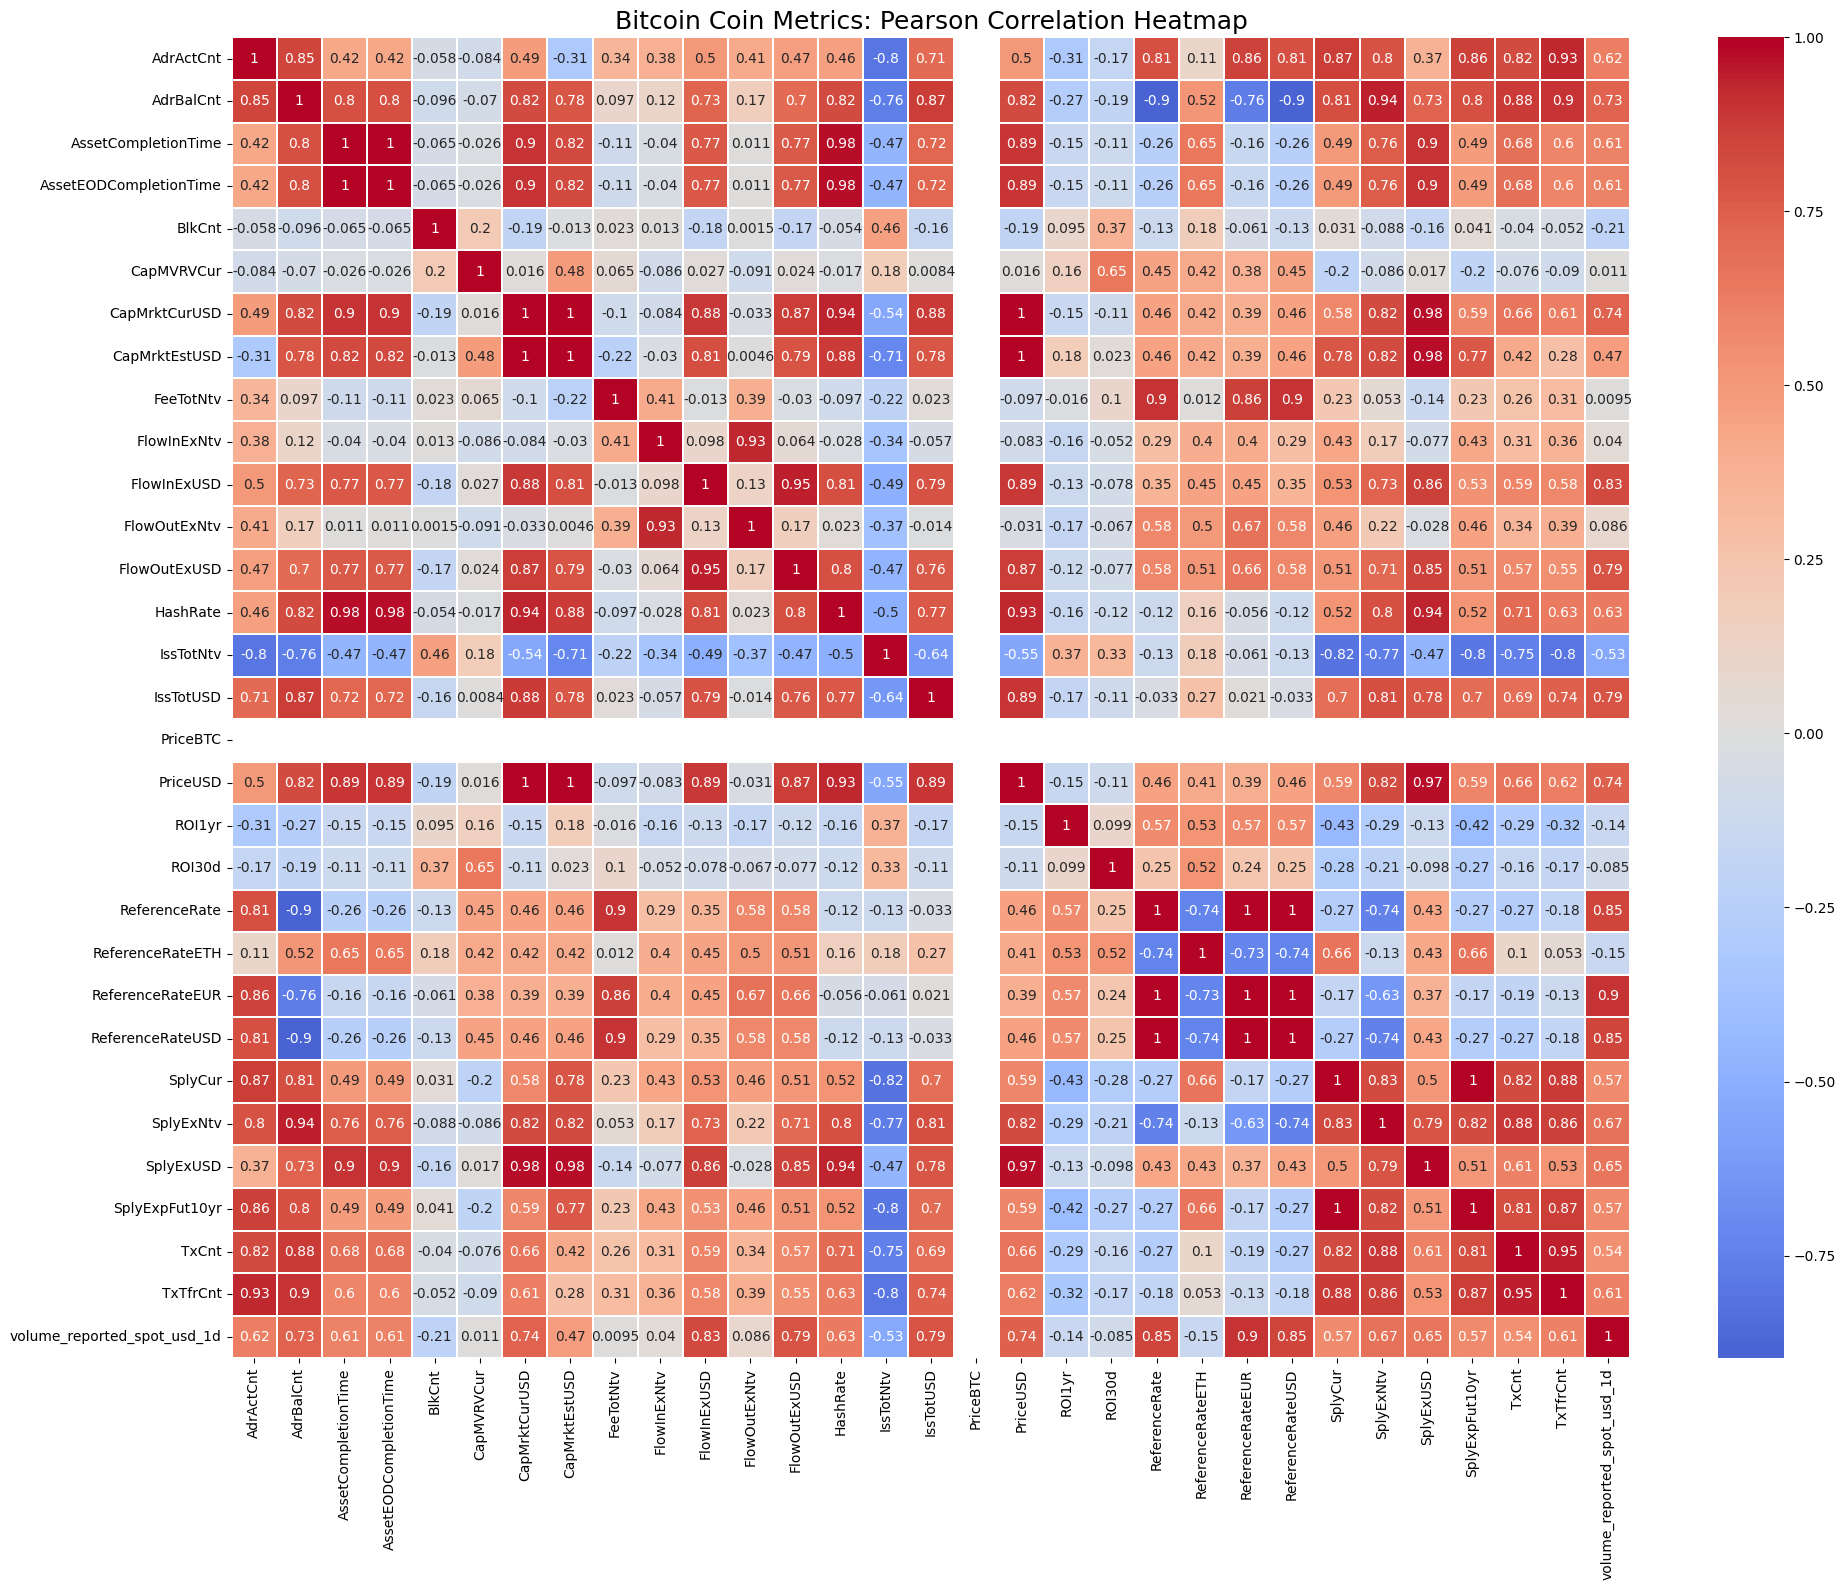

In [8]:
# Correlation Matrix
corr_matrix = coin_df.corr(numeric_only=True)

# Save the matrix to a CSV for detailed inspection
corr_matrix.to_csv("../eda/plots/btc_correlation_results.csv")

# Plot Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix, 
    annot=True,         
    cmap='coolwarm',     
    center=0, 
    linewidths=0.1
)

plt.title('Bitcoin Coin Metrics: Pearson Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# PriceUSD Correlations
price_correlations = corr_matrix['PriceUSD'].sort_values(ascending=False)
print("Top 10 Metrics Positively Correlated with Price:")
print(price_correlations.head(11))

print("\nTop 5 Metrics Negatively Correlated with Price:")
print(price_correlations.tail(5))

In [19]:
# Rolling Quintile Binning
window = 365

def get_rolling_quintile(window_data):
    if len(window_data) < window or np.all(window_data == window_data[0]):
        return np.nan
    try:
       
        bins = pd.qcut(window_data, 5, labels=False, duplicates='drop')
        return bins[-1] + 1  # Shift 0-4 to 1-5
    except Exception:
        return np.nan

print("Calculating Rolling Quintiles (this may take a moment)...")

coin_df['mvrv_q'] = coin_df['CapMVRVCur'].rolling(window).apply(get_rolling_quintile, raw=True)
coin_df['flow_q'] = coin_df['FlowInExUSD'].rolling(window).apply(get_rolling_quintile, raw=True)

# Verify we have values
print(f"MVRV Quintiles calculated. Non-null count: {coin_df['mvrv_q'].count()}")


Calculating Rolling Quintiles (this may take a moment)...
MVRV Quintiles calculated. Non-null count: 5295


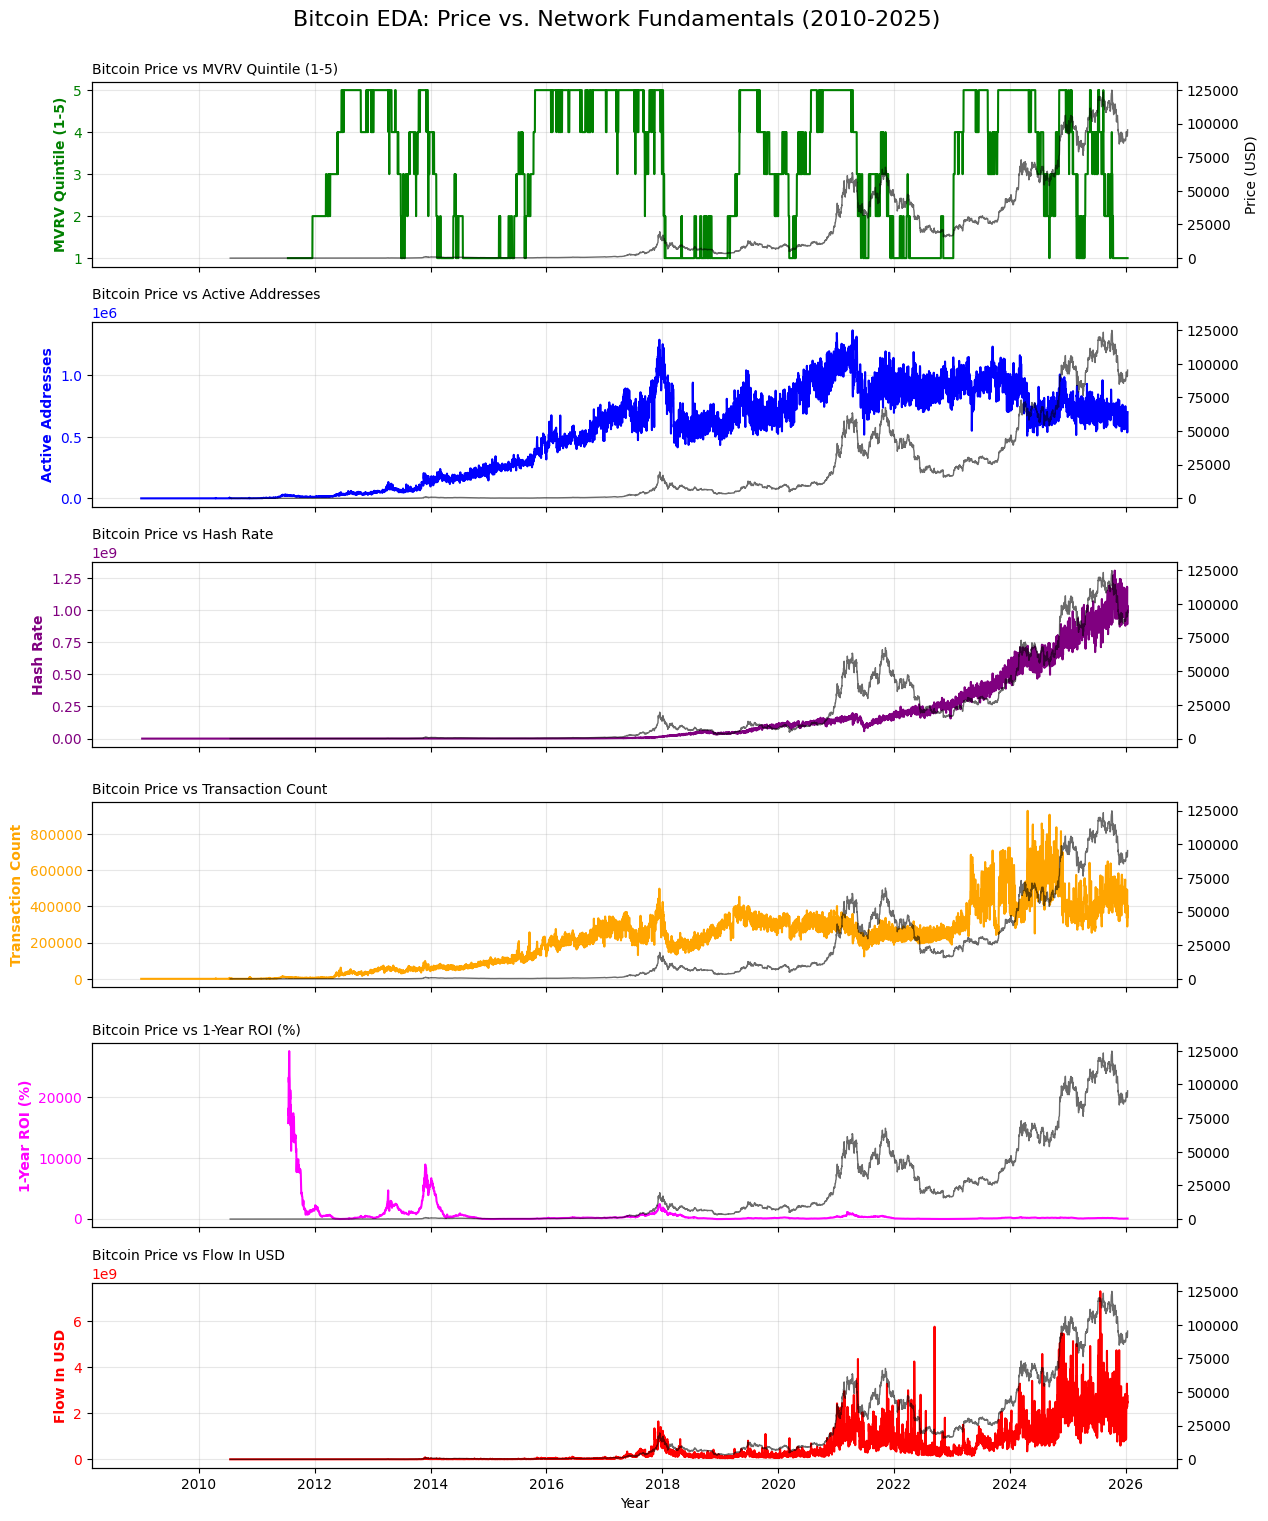

In [20]:
# Setup the Figure with 5 Subplots
fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Define our 5 Top EDA metrics and their colors
metrics = [
    ('mvrv_q', 'green', 'MVRV Quintile (1-5)'),
    ('AdrActCnt', 'blue', 'Active Addresses'),
    ('HashRate', 'purple', 'Hash Rate'),
    ('TxCnt', 'orange', 'Transaction Count'),
    ('ROI1yr', 'magenta', '1-Year ROI (%)'),
    ('FlowInExUSD', 'red', 'Flow In USD'),

]

# Loop through metrics to create the stack
for i, (col_name, color, label) in enumerate(metrics):
    ax = axes[i]
    
    # Plot the specific Metric
    ax.plot(coin_df['time'], coin_df[col_name], color=color, linewidth=1.5, label=label)
    ax.set_ylabel(label, color=color, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=color)
    ax.grid(True, alpha=0.3)
    
    # Overlay Price on a secondary axis for EVERY subplot
    ax_price = ax.twinx()
    ax_price.plot(coin_df['time'], coin_df['PriceUSD'], color='black', alpha=.58, linewidth=1)
    if i == 0:
        ax_price.set_ylabel('Price (USD)', color='black')
    
    ax.set_title(f'Bitcoin Price vs {label}', loc='left', fontsize=10)

# Final Formatting
axes[-1].set_xlabel('Year')
plt.suptitle('Bitcoin EDA: Price vs. Network Fundamentals (2010-2025)', fontsize=16, y=0.92)
plt.savefig('plots/BTC vs Network Fundamentals.png')
plt.show()

We see that there is a massive divergence in 2024 to 2025: while the price increased to $120k, several fundamental metrics (such as Active Addresses and Transaction Counts) actually leveled off or declined.

Unlike the price, the Hash Rate is a near-constant upward line. Even during the 2022 bear market, the Hash Rate continued to climb, which suggests that miners are consistently investing in long-term security of network.

In [9]:
# Perform feature engineering and create metrics
# Daily reutrns
coin_df['return_1d'] = coin_df['PriceUSD'].pct_change()
# Log returns
coin_df['logreturn_1d'] = np.log(coin_df['PriceUSD']).diff()
# 200-Day Simple Moving Average
coin_df['ma_200'] = coin_df['PriceUSD'].rolling(window=200).mean() 

/var/folders/02/nw__lfcn0wx_1ww6266fv69m0000gn/T/ipykernel_1795/1763584804.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  coin_df['return_1d'] = coin_df['PriceUSD'].pct_change()


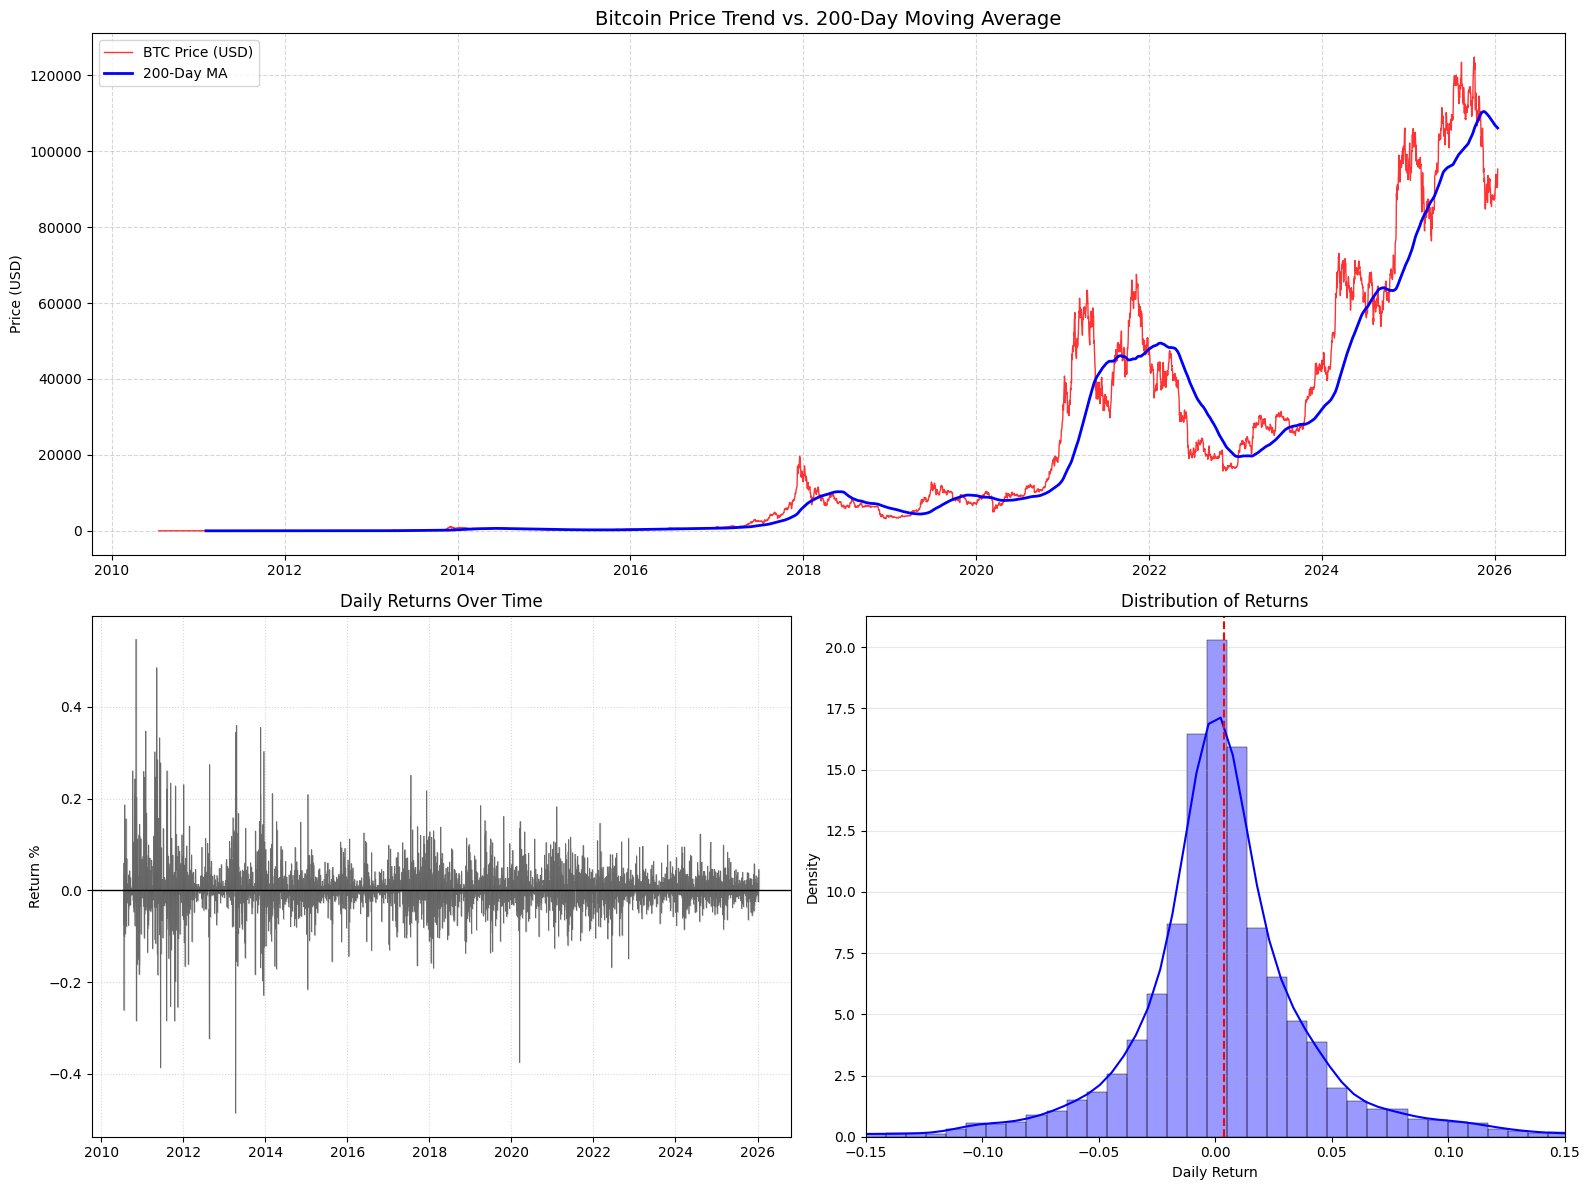

In [66]:
# Configure the subplots
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2) # Top Panel
ax2 = plt.subplot2grid((2, 2), (1, 0))            # Bottom Left
ax3 = plt.subplot2grid((2, 2), (1, 1))            # Bottom Right

# TOP PANEL: Price & 200-Day MA
ax1.plot(coin_df['time'], coin_df['PriceUSD'], color='red', label='BTC Price (USD)', linewidth=1, alpha=0.8)
ax1.plot(coin_df['time'], coin_df['ma_200'], color='blue', label='200-Day MA', linewidth=2)
ax1.set_title('Bitcoin Price Trend vs. 200-Day Moving Average', fontsize=14)
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.5)

# BOTTOM LEFT: Daily Returns (Time Series)
ax2.fill_between(coin_df['time'], coin_df['return_1d'], color='gray', alpha=0.3)
ax2.plot(coin_df['time'], coin_df['return_1d'], color='black', linewidth=0.5, alpha=0.5)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title('Daily Returns Over Time', fontsize=12)
ax2.set_ylabel('Return %')
ax2.grid(True, linestyle=':', alpha=0.5)

# BOTTOM RIGHT: Histogram (Distribution)
clean_returns = coin_df['return_1d'].dropna()
sns.histplot(clean_returns, bins=120, kde=True, color='blue', ax=ax3, stat="density", alpha=0.4)
ax3.axvline(clean_returns.mean(), color='red', linestyle='--', label='Mean')
ax3.set_title('Distribution of Returns', fontsize=12)
ax3.set_xlabel('Daily Return')
ax3.set_xlim(-0.15, 0.15) 
ax3.grid(axis='y', alpha=0.3)

# Final Polish
plt.tight_layout()
plt.savefig('plots/BTC vs MVRT.png')
plt.show()

In [11]:
# Calculate the mean of daily return and annualized mean return 
daily_mean = coin_df['return_1d'].mean()
daily_median = coin_df['return_1d'].median()

print(f"Daily Mean Return: {daily_mean:.4%}")
print(f"Daily Median Return: {daily_median:.4%}")

# Annualized version (assuming 365 trading days)
print(f"Annualized Mean Return: {(1 + daily_mean)**365 - 1:.2%}")

Daily Mean Return: 0.3574%
Daily Median Return: 0.1470%
Annualized Mean Return: 267.75%


The 200 Day Moving Average (blue line) seems to be a perfect support for during the 2024 climb. However, as of early 2026, the price line is significantly above the blue line, hinting the need for the average to catch up.

The massiv spiked on daily returns from the early 2010s are gone and it seems to be relatively stable towards 2026. While the "typical" day for Bitcoin is quiet (0.15% median), the average is pulled upward by massive positive spikes to a 0.36% daily mean. This small daily edge, when compounded over a year, results in an extraordinary 267.75% annualized return, illustrating Bitcoin's characteristic "positive skew."

# Polymarket

In [12]:
# Load data using lazy evaluation
poly_data = eda.load_polymarket_data(POLYMARKET_DIR)
markets_df = poly_data.get("markets")
odds_df = poly_data.get("odds")
summary_df = poly_data.get("summary")
tokens_df = poly_data.get("tokens")


Loading Polymarket data from /Users/kshitijgurung/Desktop/OMSA GT/practicum/bitcoin-analytics-capstone/data/Polymarket...
[Memory] Before loading Polymarket data: 270.69 MB
Loaded 78321 markets.
Loaded 2143181 odds history records.
Loaded 78321 summary records.
Loaded 44033 events records.
Loaded 156636 tokens records.
[Memory] After loading Polymarket data: 173.55 MB (Δ -97.14 MB)


In [24]:
# Overview of the polymarket data summary
eda.analyze_polymarket_summary(poly_data)


--- Polymarket Data Summary ---
Total Markets: 78321
Active Markets: 78321
Closed Markets: 0
Total Volume: $18,203,500,864.53
Average Volume per Market: $232,421.71
Total Odds History Records: 2,143,181
Total Trades: 27,013,724


In [13]:
print(markets_df.columns)
markets_df.sort(by='volume', descending=True)[:10, :]

['market_id', 'question', 'slug', 'event_slug', 'category', 'volume', 'active', 'closed', 'created_at', 'end_date']


market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date
str,str,str,str,str,f64,bool,bool,datetime[μs],datetime[μs]
"""253591""","""Will Donald Trump win the 2024…","""will-donald-trump-win-the-2024…","""presidential-election-winner-2…","""""",1.5315e9,true,true,2024-01-04 17:33:51,2024-11-05 12:00:00
"""253597""","""Will Kamala Harris win the 202…","""will-kamala-harris-win-the-202…","""presidential-election-winner-2…","""""",1.0370e9,true,true,2024-01-04 17:40:17,2024-11-04 12:00:00
"""511754""","""Will Donald Trump be inaugurat…","""will-donald-trump-be-inaugurat…","""who-will-be-inaugurated-as-pre…","""""",4.0041e8,true,true,2024-11-01 20:59:58,2025-01-20 12:00:00
"""512340""","""Will Nicolae Ciucă win the 202…","""will-nicolae-ciuca-win-the-202…","""romania-presidential-election""","""""",3.2651e8,true,true,2024-11-07 23:53:29,2024-12-08 12:00:00
"""253642""","""Will any other Republican Poli…","""will-any-other-republican-poli…","""presidential-election-winner-2…","""""",2.4166e8,true,true,2024-01-06 19:52:35,2024-11-05 00:00:00
"""253727""","""Kamala Harris wins the popular…","""will-kamala-harris-win-the-pop…","""presidential-election-popular-…","""""",1.6378e8,true,true,2024-01-09 18:29:49,2024-11-05 12:00:00
"""253609""","""Will Michelle Obama win the 20…","""will-michelle-obama-win-the-20…","""presidential-election-winner-2…","""""",1.5338e8,true,true,2024-01-05 20:53:17,2024-11-05 00:00:00
"""538932""","""Will Zohran Mamdani win the 20…","""will-zohran-mamdani-win-the-20…","""new-york-city-mayoral-election""","""""",1.4325e8,true,true,2025-04-22 15:32:27,2025-11-04 12:00:00
"""253595""","""Will Robert F. Kennedy Jr. win…","""will-robert-f-kennedy-jr-win-t…","""presidential-election-winner-2…","""""",1.4161e8,true,true,2024-01-04 17:39:07,2024-11-04 12:00:00


In [25]:
# Extract unique categories values
unique_categories = markets_df["category"].unique().to_list()
print(f"Total Categories Found: {len(unique_categories)}")
print(unique_categories)

# Define keywords and target categories
btc_keywords = ['BTC', 'Bitcoin', 'Crypto', 'ETH', 'Ethereum', 'Solana', 'SOL', 
    'ETF', 'SEC', 'Fed', 'Stablecoin', 'RWA', 'Tokenization', 
    'AI Agent', 'Memecoin', 'Binance', 'Coinbase']
target_categories = ["Crypto", "Business", "Politics"] 

# Filter markets dataset to keep BTC related data
btc_markets = markets_df.filter(
    (pl.col("category").is_in(target_categories)) |
    (pl.col("question").str.contains_any(btc_keywords, ascii_case_insensitive=True))
)

print(f"Total markets: {len(markets_df)}")
print(f"BTC-related markets: {len(btc_markets)} ({len(btc_markets)/len(markets_df)*100:.1f}%)")

Total Categories Found: 11
['', 'Business', 'Coronavirus-', 'US-current-affairs', 'Coronavirus', 'Politics', 'Ukraine & Russia', 'Pop-Culture ', 'Global Politics', 'Tech', 'Crypto']
Total markets: 78321
BTC-related markets: 59756 (76.3%)


/var/folders/02/nw__lfcn0wx_1ww6266fv69m0000gn/T/ipykernel_1795/3078426897.py:9: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


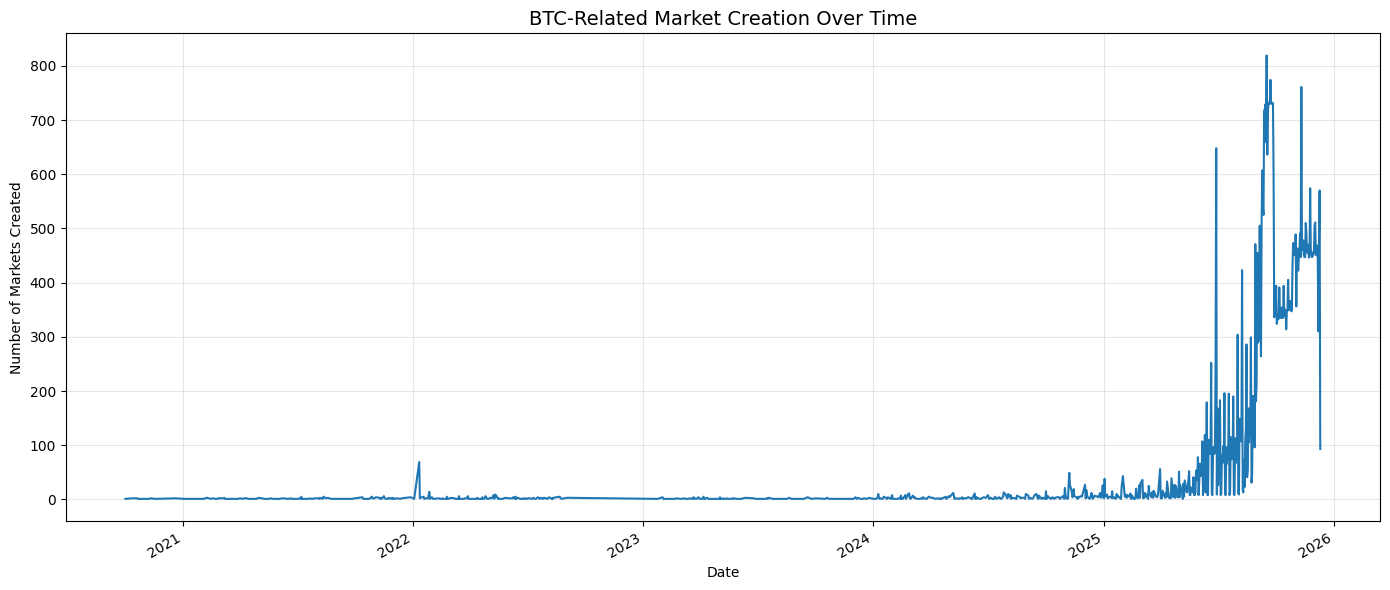


Peak activity: 2025-09-16 (819 markets)


In [16]:
# Create the date-only column
btc_markets = btc_markets.with_columns(
    pl.col("created_at").dt.date().alias("created_date"))

# Group by the date and count occurrences
daily_creation = (
    btc_markets.group_by("created_date")
    .count()
    .sort("created_date")
)

# Convert to Pandas for plotting
plot_data = daily_creation.to_pandas().set_index("created_date")
fig, ax = plt.subplots(figsize=(14, 6))
plot_data["count"].plot(ax=ax, linewidth=1.5)

ax.set_title('BTC-Related Market Creation Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Markets Created')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find Peak Activity
peak_row = daily_creation.sort("count", descending=True).head(1)
print(f"\nPeak activity: {peak_row['created_date'][0]} ({peak_row['count'][0]} markets)")

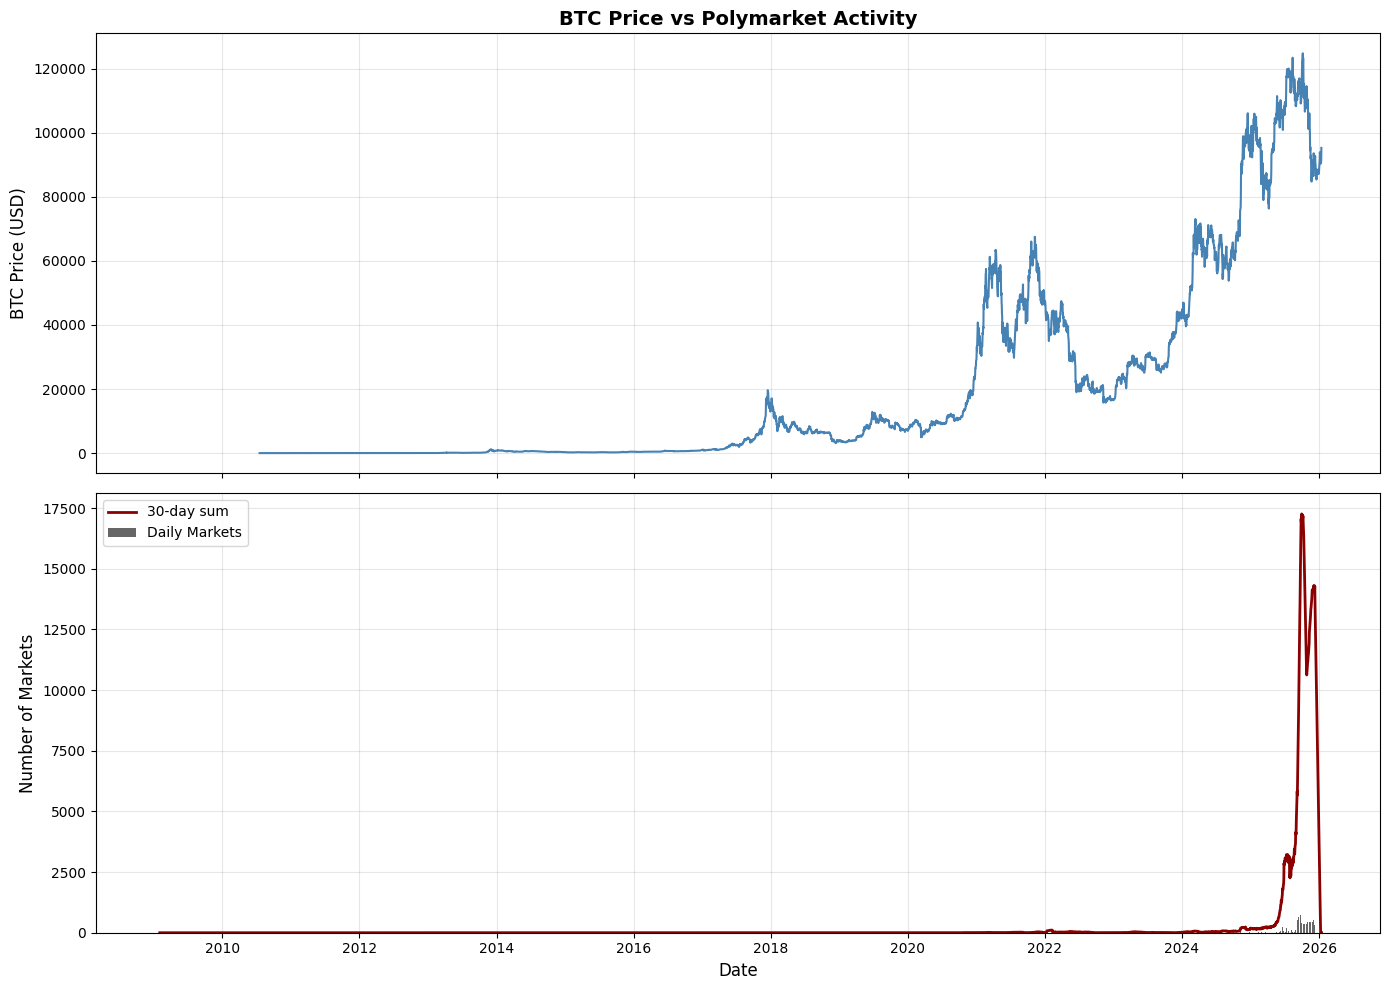

In [70]:
# Merge Ploymarket Markets data with coin metrics data (BTC Price)

# Prepare Polymarket data
poly_activity = daily_creation.to_pandas().rename(columns={'count': 'market_count'})
poly_activity['created_date'] = pd.to_datetime(poly_activity['created_date'])
poly_activity = poly_activity.set_index('created_date')

# Prepare BTC data
btc_subset = coin_df.copy()
if 'time' in btc_subset.columns:
    btc_subset['time'] = pd.to_datetime(btc_subset['time'])
    btc_subset = btc_subset.set_index('time')

# Merge Polymarket activity with BTC Price
activity_df = btc_subset[['PriceUSD']].join(poly_activity, how='left')

# Create the Rolling Metrics for market count
activity_df['market_count'] = activity_df['market_count'].fillna(0)
activity_df['market_count_30d'] = activity_df['market_count'].rolling(30).sum()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top Panel: BTC Price
ax1.plot(activity_df.index, activity_df['PriceUSD'], linewidth=1.5, color='steelblue')
ax1.set_ylabel('BTC Price (USD)', fontsize=12)
ax1.set_title('BTC Price vs Polymarket Activity', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Bottom Panel: Markets & Rolling Sum
ax2.bar(activity_df.index, activity_df['market_count'], alpha=0.6, color='black', label='Daily Markets')
ax2.plot(activity_df.index, activity_df['market_count_30d'], linewidth=2, color='darkred', label='30-day sum')
ax2.set_ylabel('Number of Markets', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/BTC vs PM.png')
plt.show()

In [26]:
# Exploring the relationship between BTC price and Market Creation
# We use percent change to normalize the growth of both metrics
analysis_df = activity_df[['market_count_30d', 'PriceUSD']].copy()
analysis_df['price_ret_30d'] = analysis_df['PriceUSD'].pct_change(30)
analysis_df['market_growth_30d'] = analysis_df['market_count_30d'].pct_change(30)

# Drop NaNs and Infinity to prevent division by zero
corr_df = analysis_df[['market_growth_30d', 'price_ret_30d']].replace([np.inf, -np.inf], np.nan).dropna()

# Perform the Correlation
if len(corr_df) > 30:
    corr, p_value = stats.pearsonr(corr_df['market_growth_30d'], corr_df['price_ret_30d'])
    
    print(f"--- Correlation Analysis (30-Day Growth) ---")
    print(f"Correlation: {corr:.3f}")
    print(f"P-Value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: Statistically Significant")
    else:
        print("Result: Not Statistically Significant (Noise)")

--- Correlation Analysis (30-Day Growth) ---
Correlation: 0.131
P-Value: 0.0000
Result: Statistically Significant


/var/folders/02/nw__lfcn0wx_1ww6266fv69m0000gn/T/ipykernel_1795/3081759270.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  analysis_df['price_ret_30d'] = analysis_df['PriceUSD'].pct_change(30)


Althought the correlation between Bitcoin price and Polymarket market creation count is statisticlaly significant, the weak pearson correlation of 0.131 tells us that there is a very weak tendency for market creation to increase when BTC price goes up.

In [30]:
# Explore relationship between BTC related topics being bet on daily basis and volume intensity
daily_pm_features = (
    btc_markets.filter(pl.col("created_at").is_not_null())
    # Create the date grouping key
    .with_columns(pl.col("created_at").dt.date().alias("date"))
    .group_by("date")
    .agg([
        pl.len().alias("pm_new_market_count"), # Faster than pl.count("market_id")
        pl.col("volume").sum().alias("pm_daily_volume"),
        # pl.col("liquidity").mean().alias("pm_avg_liquidity"),
        # Calculate duration inside agg using a simple mean of the difference
        ((pl.col("end_date") - pl.col("created_at")).dt.total_days()).mean().alias("avg_market_duration")
    ])
    # Calculate Intensity after the aggregation is finished
    .with_columns(
        (pl.col("pm_daily_volume") / pl.col("pm_new_market_count")).alias("pm_volume_intensity")
    )
    .sort("date")
)

print(daily_pm_features.head())
daily_pm_features.describe()

shape: (5, 5)
┌────────────┬─────────────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ date       ┆ pm_new_market_count ┆ pm_daily_volume ┆ avg_market_duration ┆ pm_volume_intensity │
│ ---        ┆ ---                 ┆ ---             ┆ ---                 ┆ ---                 │
│ date       ┆ u32                 ┆ f64             ┆ f64                 ┆ f64                 │
╞════════════╪═════════════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ 2020-10-02 ┆ 1                   ┆ 59755.8         ┆ 32.0                ┆ 59755.8             │
│ 2020-10-12 ┆ 2                   ┆ 116891.68       ┆ 58.0                ┆ 58445.84            │
│ 2020-10-21 ┆ 2                   ┆ 163138.09       ┆ 40.5                ┆ 81569.045           │
│ 2020-10-22 ┆ 1                   ┆ 224706.49       ┆ 70.0                ┆ 224706.49           │
│ 2020-11-04 ┆ 1                   ┆ 560270.42       ┆ 27.0                ┆ 560270.42         

statistic,date,pm_new_market_count,pm_daily_volume,avg_market_duration,pm_volume_intensity
str,str,f64,f64,f64,f64
"""count""","""844""",844.0,844.0,840.0,844.0
"""null_count""","""0""",0.0,0.0,4.0,0.0
"""mean""","""2024-01-08 21:04:15.924000""",70.800948,7.2797e6,35.878828,513461.446441
"""std""",null,160.302526,2.1657e7,63.28142,1.8966e6
"""min""","""2020-10-02""",1.0,0.0,-132.5,0.0
"""25%""","""2022-07-20""",1.0,53434.365014,2.425714,22500.810514
"""50%""","""2024-06-13""",3.0,482670.78,8.25,65125.043333
"""75%""","""2025-05-13""",16.0,5.7962e6,39.0,243065.41
"""max""","""2025-12-10""",819.0,2.8416e8,365.0,3.0208e7


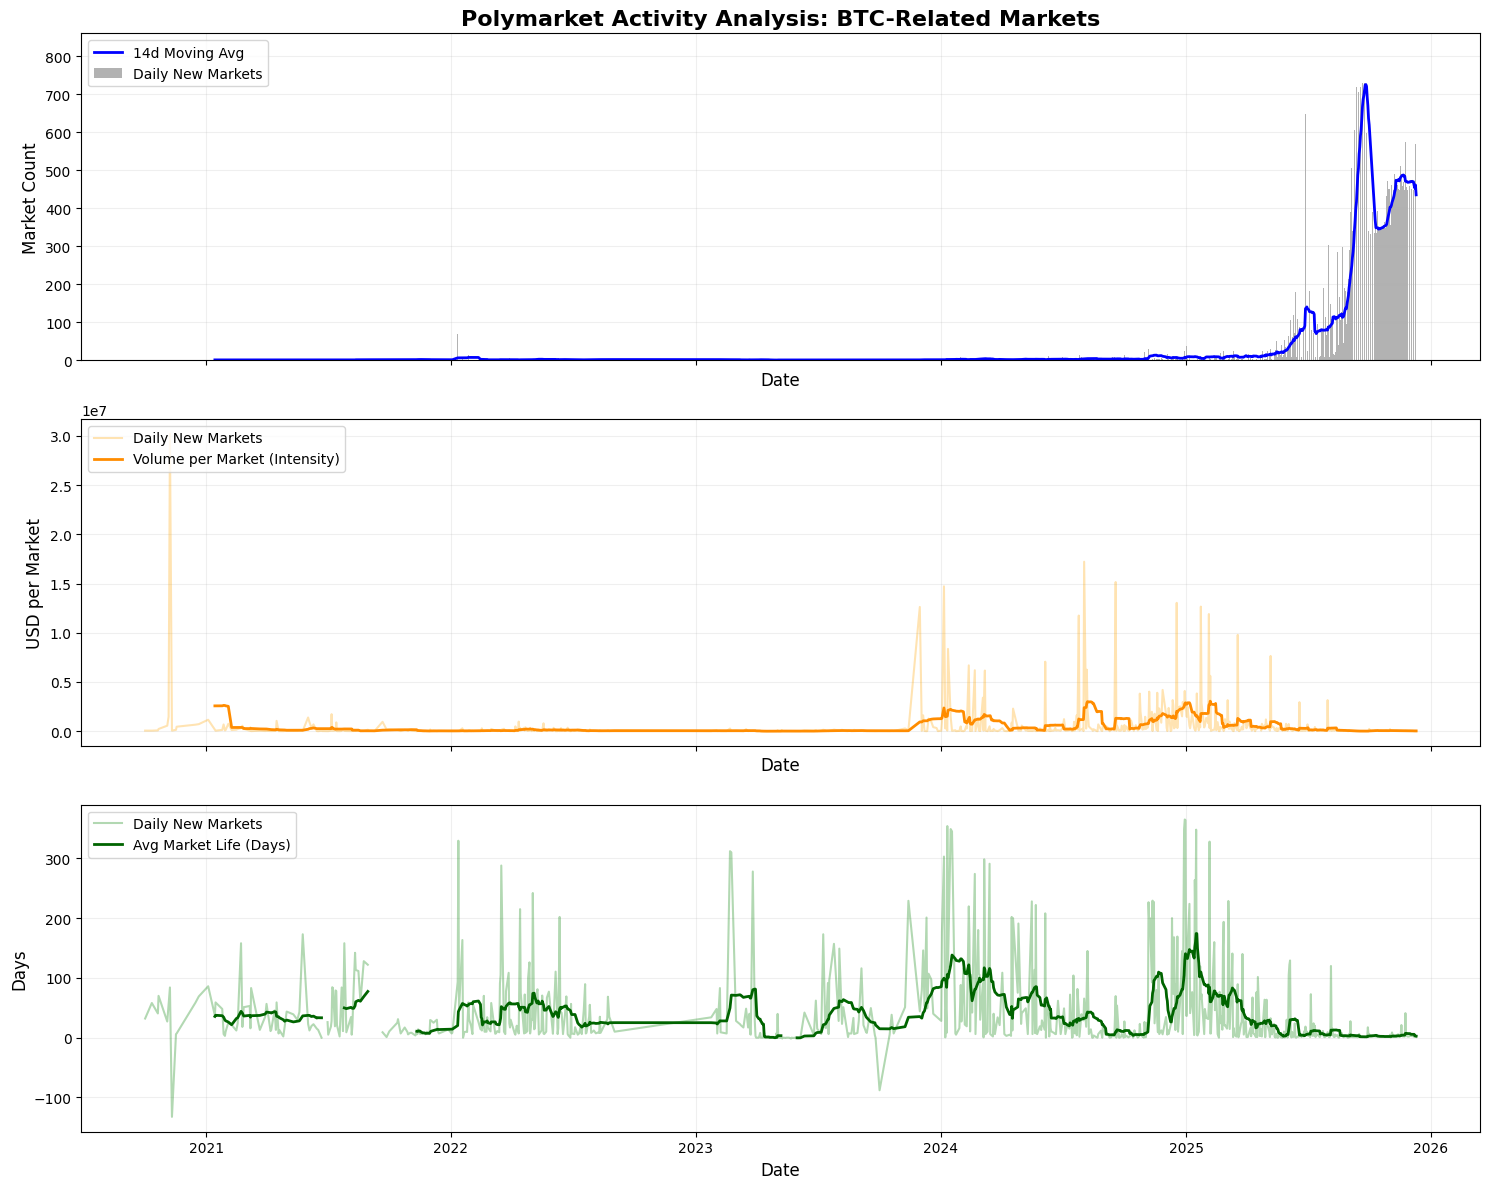

In [69]:
# Convert Polars to Pandas for Visualization
plot_df = daily_pm_features.to_pandas()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df = plot_df.set_index('date')

# Calculate Rolling Averages (14 days) to smooth out the noise
window = 14
plot_df['count_sma'] = plot_df['pm_new_market_count'].rolling(window).mean()
plot_df['intensity_sma'] = plot_df['pm_volume_intensity'].rolling(window).mean()
plot_df['duration_sma'] = plot_df['avg_market_duration'].rolling(window).mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Top Chart: Market Count (The Pulse)
ax1.bar(plot_df.index, plot_df['pm_new_market_count'], color='black', alpha=0.3, label='Daily New Markets')
ax1.plot(plot_df.index, plot_df['count_sma'], color='blue', linewidth=2, label=f'{window}d Moving Avg')
ax1.set_title('Polymarket Activity Analysis: BTC-Related Markets', fontsize=16, fontweight='bold')
ax1.set_ylabel('Market Count', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.2)

# Middle Chart: Volume Intensity (The Conviction)
# Using a log scale here is often helpful if you have massive volume spikes
ax2.plot(plot_df.index, plot_df['pm_volume_intensity'], color='orange', alpha=0.3, label='Daily New Markets')
ax2.plot(plot_df.index, plot_df['intensity_sma'], color='darkorange', linewidth=2, label='Volume per Market (Intensity)')
ax2.set_ylabel('USD per Market', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

# Bottom Chart: Average Duration (The Time Horizon)
ax3.plot(plot_df.index, plot_df['avg_market_duration'], color='green', alpha=0.3, label='Daily New Markets')
ax3.plot(plot_df.index, plot_df['duration_sma'], color='darkgreen', linewidth=2, label='Avg Market Life (Days)')
ax3.set_ylabel('Days', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('plots/BTC vs MarDay.png')
plt.show()

* The "Intensity" spikes reveal that big-money traders often entered the market in concentrated brusts rather than steady flows
* The recent drop in market duration suggests that traders have shifted from "long-term investing" to "high-stakes gambling"

# Odds

In [21]:
print(odds_df.shape)
odds_df.head()

(2143181, 4)


market_id,token_id,timestamp,price
str,str,datetime[μs],f64
"""255140""","""474357953615233060686693901910…",2024-06-08 00:00:02,0.055
"""255140""","""474357953615233060686693901910…",2024-06-09 00:00:03,0.055
"""255140""","""474357953615233060686693901910…",2024-06-10 00:00:04,0.055
"""255140""","""474357953615233060686693901910…",2024-06-11 00:00:02,0.055
"""255140""","""474357953615233060686693901910…",2024-06-12 00:00:03,0.055


In [37]:
# Grouping by date and market it for easier comparative analysis
odds_daily = (
    odds_df.with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by(["date", "market_id"])
    .agg([
        pl.col("price").mean().alias("avg_daily_odds"),
        pl.col("price").std().alias("odds_volatility"),
        pl.len().alias("tick_count") # How many times the price changed that day
    ])
    .sort("date")
)

print(odds_daily.head())

shape: (5, 5)
┌────────────┬───────────┬────────────────┬─────────────────┬────────────┐
│ date       ┆ market_id ┆ avg_daily_odds ┆ odds_volatility ┆ tick_count │
│ ---        ┆ ---       ┆ ---            ┆ ---             ┆ ---        │
│ date       ┆ str       ┆ f64            ┆ f64             ┆ u32        │
╞════════════╪═══════════╪════════════════╪═════════════════╪════════════╡
│ 2023-01-24 ┆ 248444    ┆ 0.505          ┆ 0.657609        ┆ 2          │
│ 2023-01-25 ┆ 248451    ┆ 0.505          ┆ 0.671751        ┆ 2          │
│ 2023-01-25 ┆ 248444    ┆ 0.505          ┆ 0.671751        ┆ 2          │
│ 2023-01-26 ┆ 248444    ┆ 0.505          ┆ 0.671751        ┆ 2          │
│ 2023-01-26 ┆ 248451    ┆ 0.5            ┆ 0.650538        ┆ 2          │
└────────────┴───────────┴────────────────┴─────────────────┴────────────┘


In [40]:
# Join odds with BTC-related markets
btc_odds_daily = odds_daily.join(
    btc_markets.select("market_id"), 
    on="market_id", 
    how="semi"
)
# Calculate a global average of 'probabilities' across all BTC markets for each day
daily_sentiment = (
    btc_odds_daily.group_by("date")
    .agg([
        pl.col("avg_daily_odds").mean().alias("pm_sentiment_index"),
        pl.col("odds_volatility").mean().alias("pm_avg_uncertainty"),
        pl.col("tick_count").sum().alias("pm_total_price_updates")
    ])
    .sort("date")
)

In [44]:
# cleanup data
daily_sentiment = daily_sentiment.with_columns(
    pl.col("date").cast(pl.Date)
)
if not isinstance(activity_df, pl.DataFrame):
    # Reset index, time
    activity_polars = pl.from_pandas(activity_df.reset_index())
    
    if "index" in activity_polars.columns:
        activity_polars = activity_polars.rename({"index": "date"})
    elif "time" in activity_polars.columns:
        activity_polars = activity_polars.rename({"time": "date"})

    # FORCE this to be a Date (not datetime)
    activity_polars = activity_polars.with_columns(
        pl.col("date").cast(pl.Date)
    )

final_master_df = daily_sentiment.join(activity_polars, on="date", how="inner")
print(final_master_df.head())

shape: (5, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ date       ┆ pm_sentiment ┆ pm_avg_uncer ┆ pm_total_pr ┆ PriceUSD    ┆ market_coun ┆ market_coun │
│ ---        ┆ _index       ┆ tainty       ┆ ice_updates ┆ ---         ┆ t           ┆ t_30d       │
│ date       ┆ ---          ┆ ---          ┆ ---         ┆ f64         ┆ ---         ┆ ---         │
│            ┆ f64          ┆ f64          ┆ u32         ┆             ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2023-01-31 ┆ 0.505        ┆ 0.671751     ┆ 2           ┆ 23130.05191 ┆ 0.0         ┆ 1.0         │
│            ┆              ┆              ┆             ┆ 3           ┆             ┆             │
│ 2023-02-01 ┆ 0.505        ┆ 0.671751     ┆ 2           ┆ 23727.20260 ┆ 4.0         ┆ 5.0         │
│            ┆              ┆              ┆             ┆ 8           ┆     

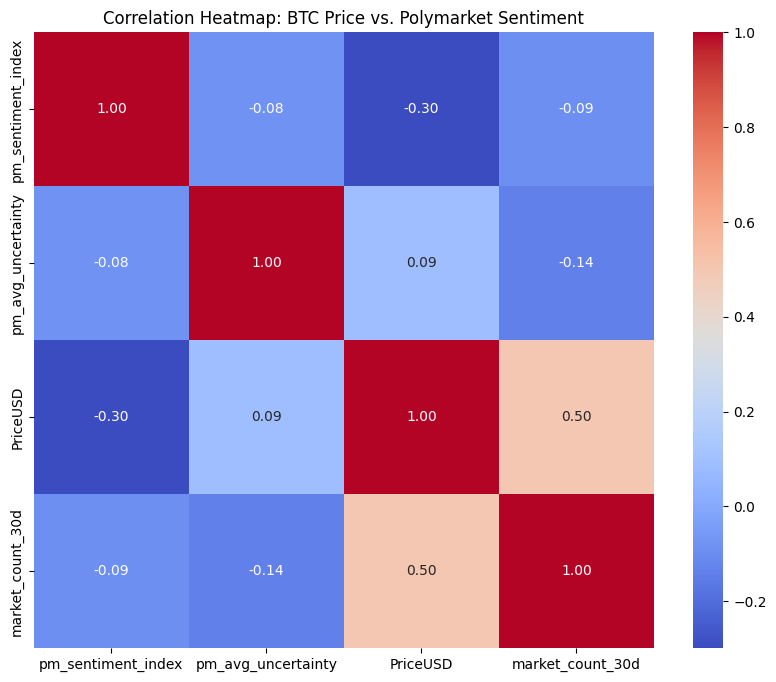

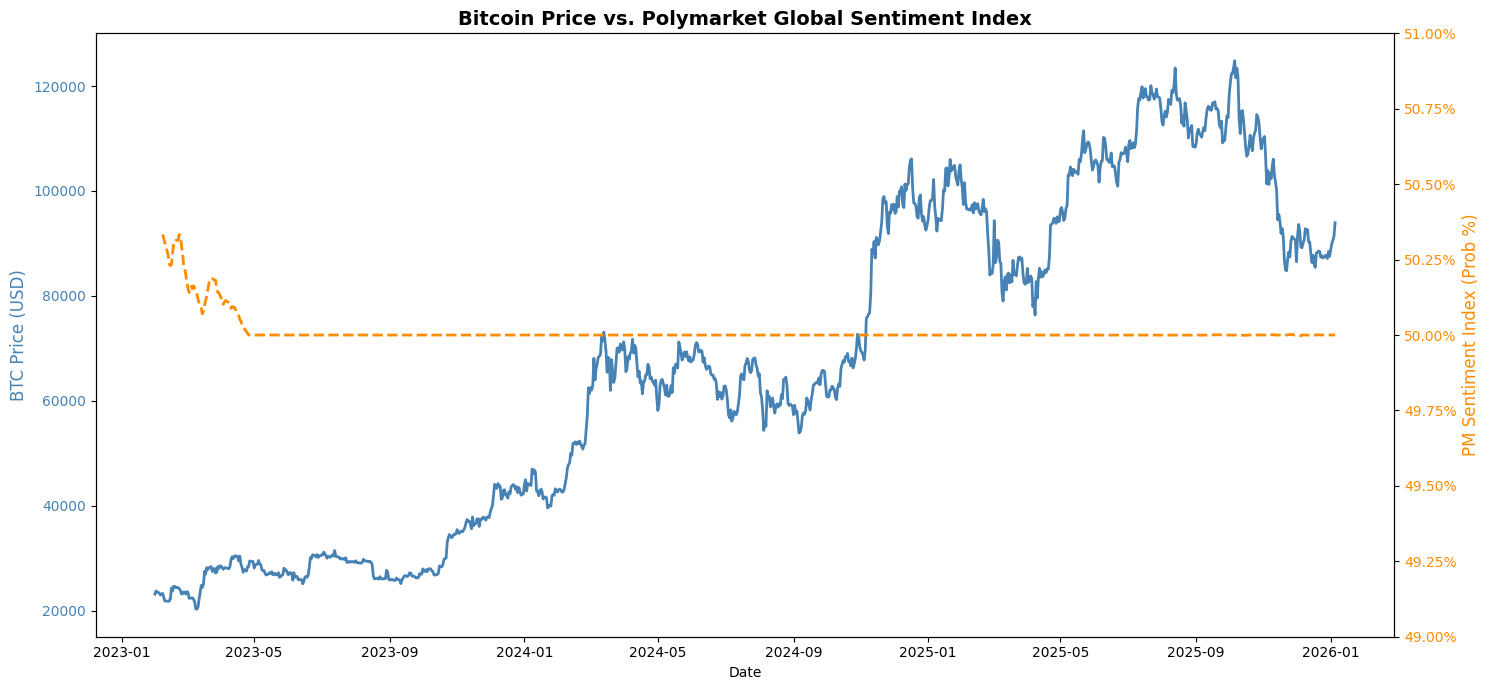

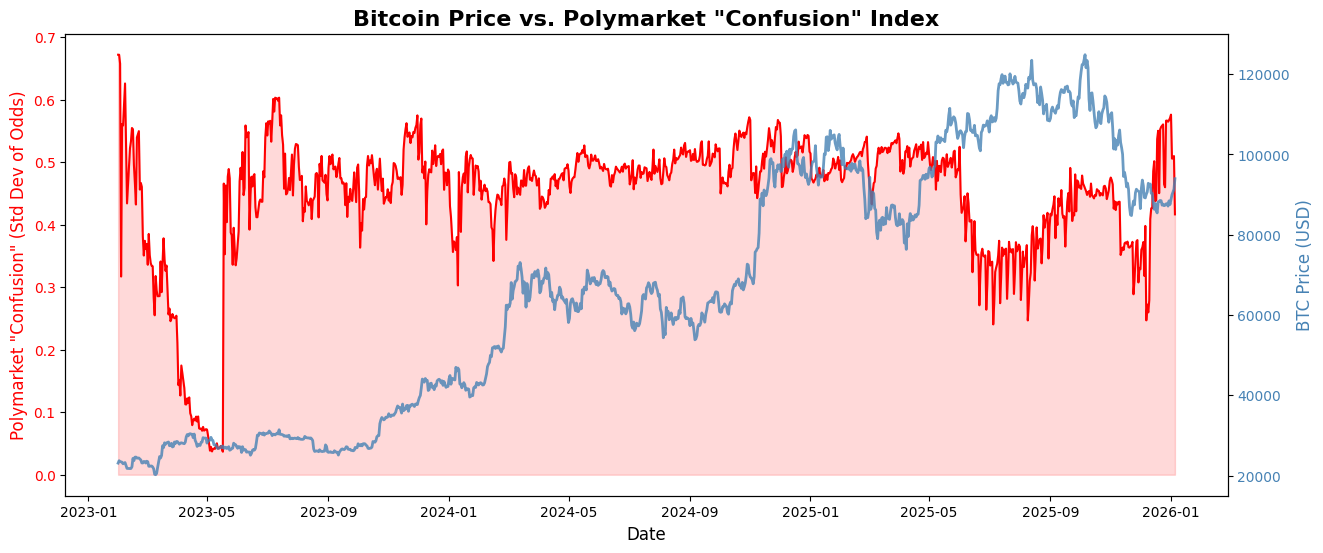

In [71]:
# Convert to Pandas for visualization
eda_p_df = final_master_df.to_pandas()
eda_p_df['date'] = pd.to_datetime(eda_p_df['date'])

# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = eda_p_df[['pm_sentiment_index', 'pm_avg_uncertainty', 'PriceUSD', 'market_count_30d']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: BTC Price vs. Polymarket Sentiment')
plt.savefig('plots/BTC vs PMCorr.png')
plt.show()

# Dual-Axis Sentiment Analysis
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot BTC Price
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color='steelblue', fontsize=12)
ax1.plot(eda_p_df['date'], eda_p_df['PriceUSD'], color='steelblue', linewidth=2, label='BTC Price')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.set_ylabel('PM Sentiment Index (Prob %)', color='darkorange', fontsize=12)

# Using a rolling mean for sentiment to see the trend
ax2.plot(eda_p_df['date'], eda_p_df['pm_sentiment_index'].rolling(7).mean(), 
         color='darkorange', linestyle='--', linewidth=2, label='7d PM Sentiment (Avg Odds)')
ax2.tick_params(axis='y', labelcolor='darkorange')

# --- THE UPDATE: Start axis from 0% ---
# This sets the bottom of the axis to 0. 
# You can also set a 'top' value (e.g., top=1.0) to show the full 0-100% range.
ax2.set_ylim(bottom=0.49, top = 0.51) 

# This formatter turns 0.5 into 50% for better readability
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

plt.title('Bitcoin Price vs. Polymarket Global Sentiment Index', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('plots/BTC vs PMSenti.png')
plt.show()
# 3. Uncertainty Analysis with BTC Price Overlay
fig, ax1 = plt.subplots(figsize=(15, 6))

# Primary Axis: Confusion Index (Uncertainty)
ax1.fill_between(eda_p_df['date'], eda_p_df['pm_avg_uncertainty'], color='red', alpha=0.15, label='Confusion Area')
ax1.plot(eda_p_df['date'], eda_p_df['pm_avg_uncertainty'], color='red', linewidth=1.5, label='Confusion (Std Dev)')
ax1.set_ylabel('Polymarket "Confusion" (Std Dev of Odds)', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Date', fontsize=12)

# Secondary Axis: BTC Price
ax2 = ax1.twinx()
ax2.plot(eda_p_df['date'], eda_p_df['PriceUSD'], color='steelblue', linewidth=2, alpha=0.8, label='BTC Price')
ax2.set_ylabel('BTC Price (USD)', color='steelblue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='steelblue')
plt.title('Bitcoin Price vs. Polymarket "Confusion" Index', fontsize=16, fontweight='bold')
plt.savefig('plots/BTC vs PMConfu.png')




In [22]:
print(summary_df.shape)
summary_df.head()

(78321, 9)


market_id,question,slug,volume,active,token_count,trade_count,first_trade,last_trade
str,str,str,f64,bool,i64,i64,datetime[μs],datetime[μs]
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,true,2,279,2025-12-09 04:35:47,2025-12-09 12:51:41
"""893560""","""Ethereum Up or Down - December…","""eth-updown-15m-1765258200""",0.0,true,2,1274,2025-12-09 04:19:37,2025-12-09 05:42:35
"""821729""","""Will the price of Solana be ab…","""solana-above-180-on-december-1…",171.504726,true,2,8,2025-12-06 00:14:15,2025-12-09 04:37:13
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,true,2,6795,2025-11-26 11:11:15,2026-01-01 05:26:25
"""556062""","""MegaETH market cap (FDV) >$2B …","""megaeth-market-cap-fdv-2b-one-…",2.6813e6,true,2,1379,2025-11-26 14:52:25,2026-01-05 04:43:39


In [57]:
# Define keywords for crypto-related markets
btc_keywords = ['BTC', 'Bitcoin', 'Crypto', 'ETH', 'Ethereum', 'Solana', 'SOL', 
                'ETF', 'SEC', 'Fed', 'Stablecoin', 'RWA', 'Tokenization', 
                'AI Agent', 'Memecoin', 'Binance', 'Coinbase']

# Filter the summary dataframe for these topics
btc_summary = summary_df.filter(
    pl.col("question").str.contains_any(btc_keywords, ascii_case_insensitive=True)
)

print(f"Total Summary Records: {len(summary_df)}")
print(f"Crypto-related Summary Records: {len(btc_summary)}")

Total Summary Records: 78321
Crypto-related Summary Records: 59469


In [58]:
# Calculate additional metrics for EDA
btc_summary_eda = btc_summary.with_columns([
    (pl.col("volume") / pl.col("trade_count")).alias("vol_per_trade"),
    pl.col("volume").log10().alias("log_volume"),
    pl.col("trade_count").log10().alias("log_trades")
])

# Top 5 most active markets by Volume
print("--- Top 5 Markets by Volume ---")
print(btc_summary_eda.sort("volume", descending=True).select(["question", "volume", "trade_count"]).head(5))

# Top 5 markets by Trade Count (High Frequency)
print("\n--- Top 5 Markets by Trade Count ---")
print(btc_summary_eda.sort("trade_count", descending=True).select(["question", "volume", "trade_count"]).head(5))

--- Top 5 Markets by Volume ---
shape: (5, 3)
┌─────────────────────────────────┬──────────┬─────────────┐
│ question                        ┆ volume   ┆ trade_count │
│ ---                             ┆ ---      ┆ ---         │
│ str                             ┆ f64      ┆ i64         │
╞═════════════════════════════════╪══════════╪═════════════╡
│ Fed increases interest rates b… ┆ 1.3396e8 ┆ 0           │
│ Fed increases interest rates b… ┆ 1.1449e8 ┆ 177785      │
│ Fed increases interest rates b… ┆ 1.0222e8 ┆ 135810      │
│ Fed decreases interest rates b… ┆ 9.8537e7 ┆ 158721      │
│ No change in Fed interest rate… ┆ 6.7369e7 ┆ 93514       │
└─────────────────────────────────┴──────────┴─────────────┘

--- Top 5 Markets by Trade Count ---
shape: (5, 3)
┌─────────────────────────────────┬──────────┬─────────────┐
│ question                        ┆ volume   ┆ trade_count │
│ ---                             ┆ ---      ┆ ---         │
│ str                             ┆ f64      ┆ i

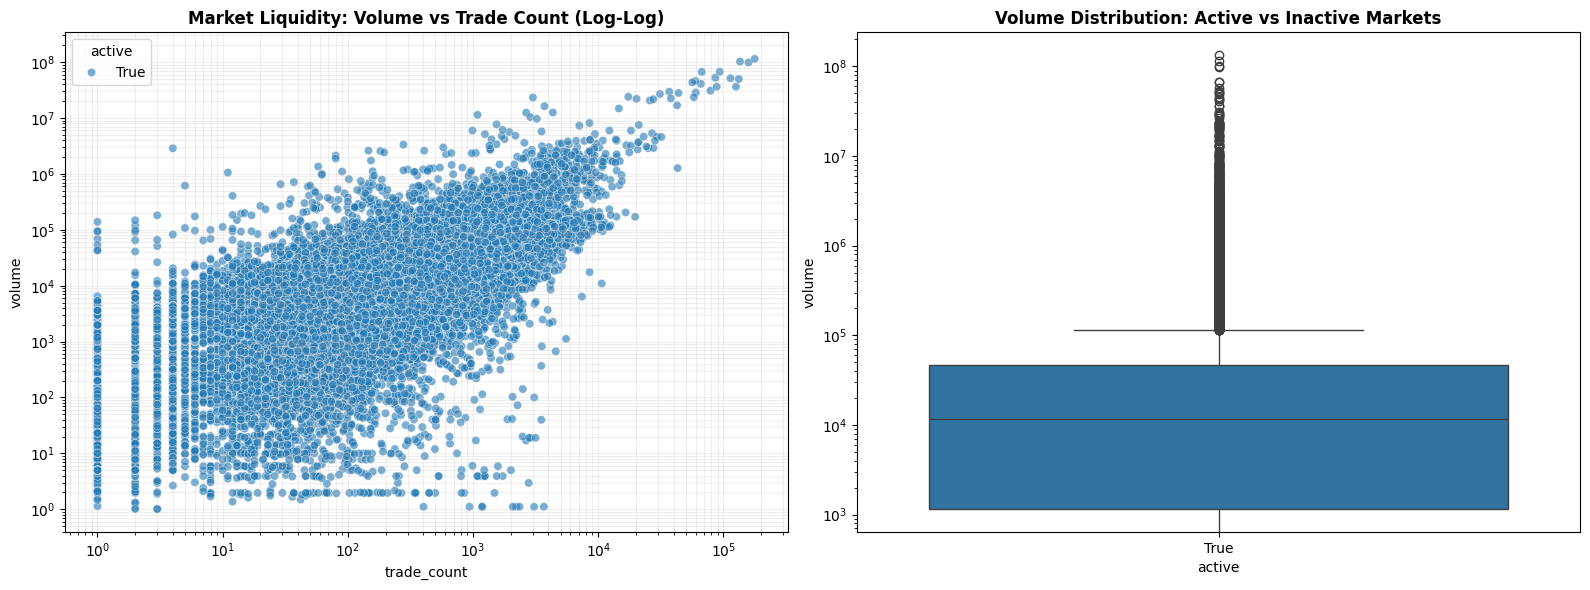

Volume-to-Trade Correlation: 0.675


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = btc_summary_eda.to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Volume vs Trade Count (Correlation)
sns.scatterplot(data=plot_df, x="trade_count", y="volume", hue="active", alpha=0.6, ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Market Liquidity: Volume vs Trade Count (Log-Log)', fontweight='bold')
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Volume Distribution
sns.boxplot(data=plot_df, x="active", y="volume", ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Volume Distribution: Active vs Inactive Markets', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate Correlation
correlation = btc_summary_eda.select(pl.corr("volume", "trade_count")).item()
print(f"Volume-to-Trade Correlation: {correlation:.3f}")